# GAP Reconstruction

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time. In particular we are focused on the gaps in the rate when the threshold is zero

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os


# Define some constants
raw_dir = '../../Data/FULL_DATA/'
# SD      = '2022-09-19' 
# raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'light1-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

SIPM_ID     = 0
PMT_ID      = 1
PAYLOAD_ID  = PMT_ID

# Decode the buffer data in a dictionary
full_data   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition=f"data['id_bit'] == {PAYLOAD_ID}")

Line:   0%|          | 0/296753 [00:00<?, ?it/s]

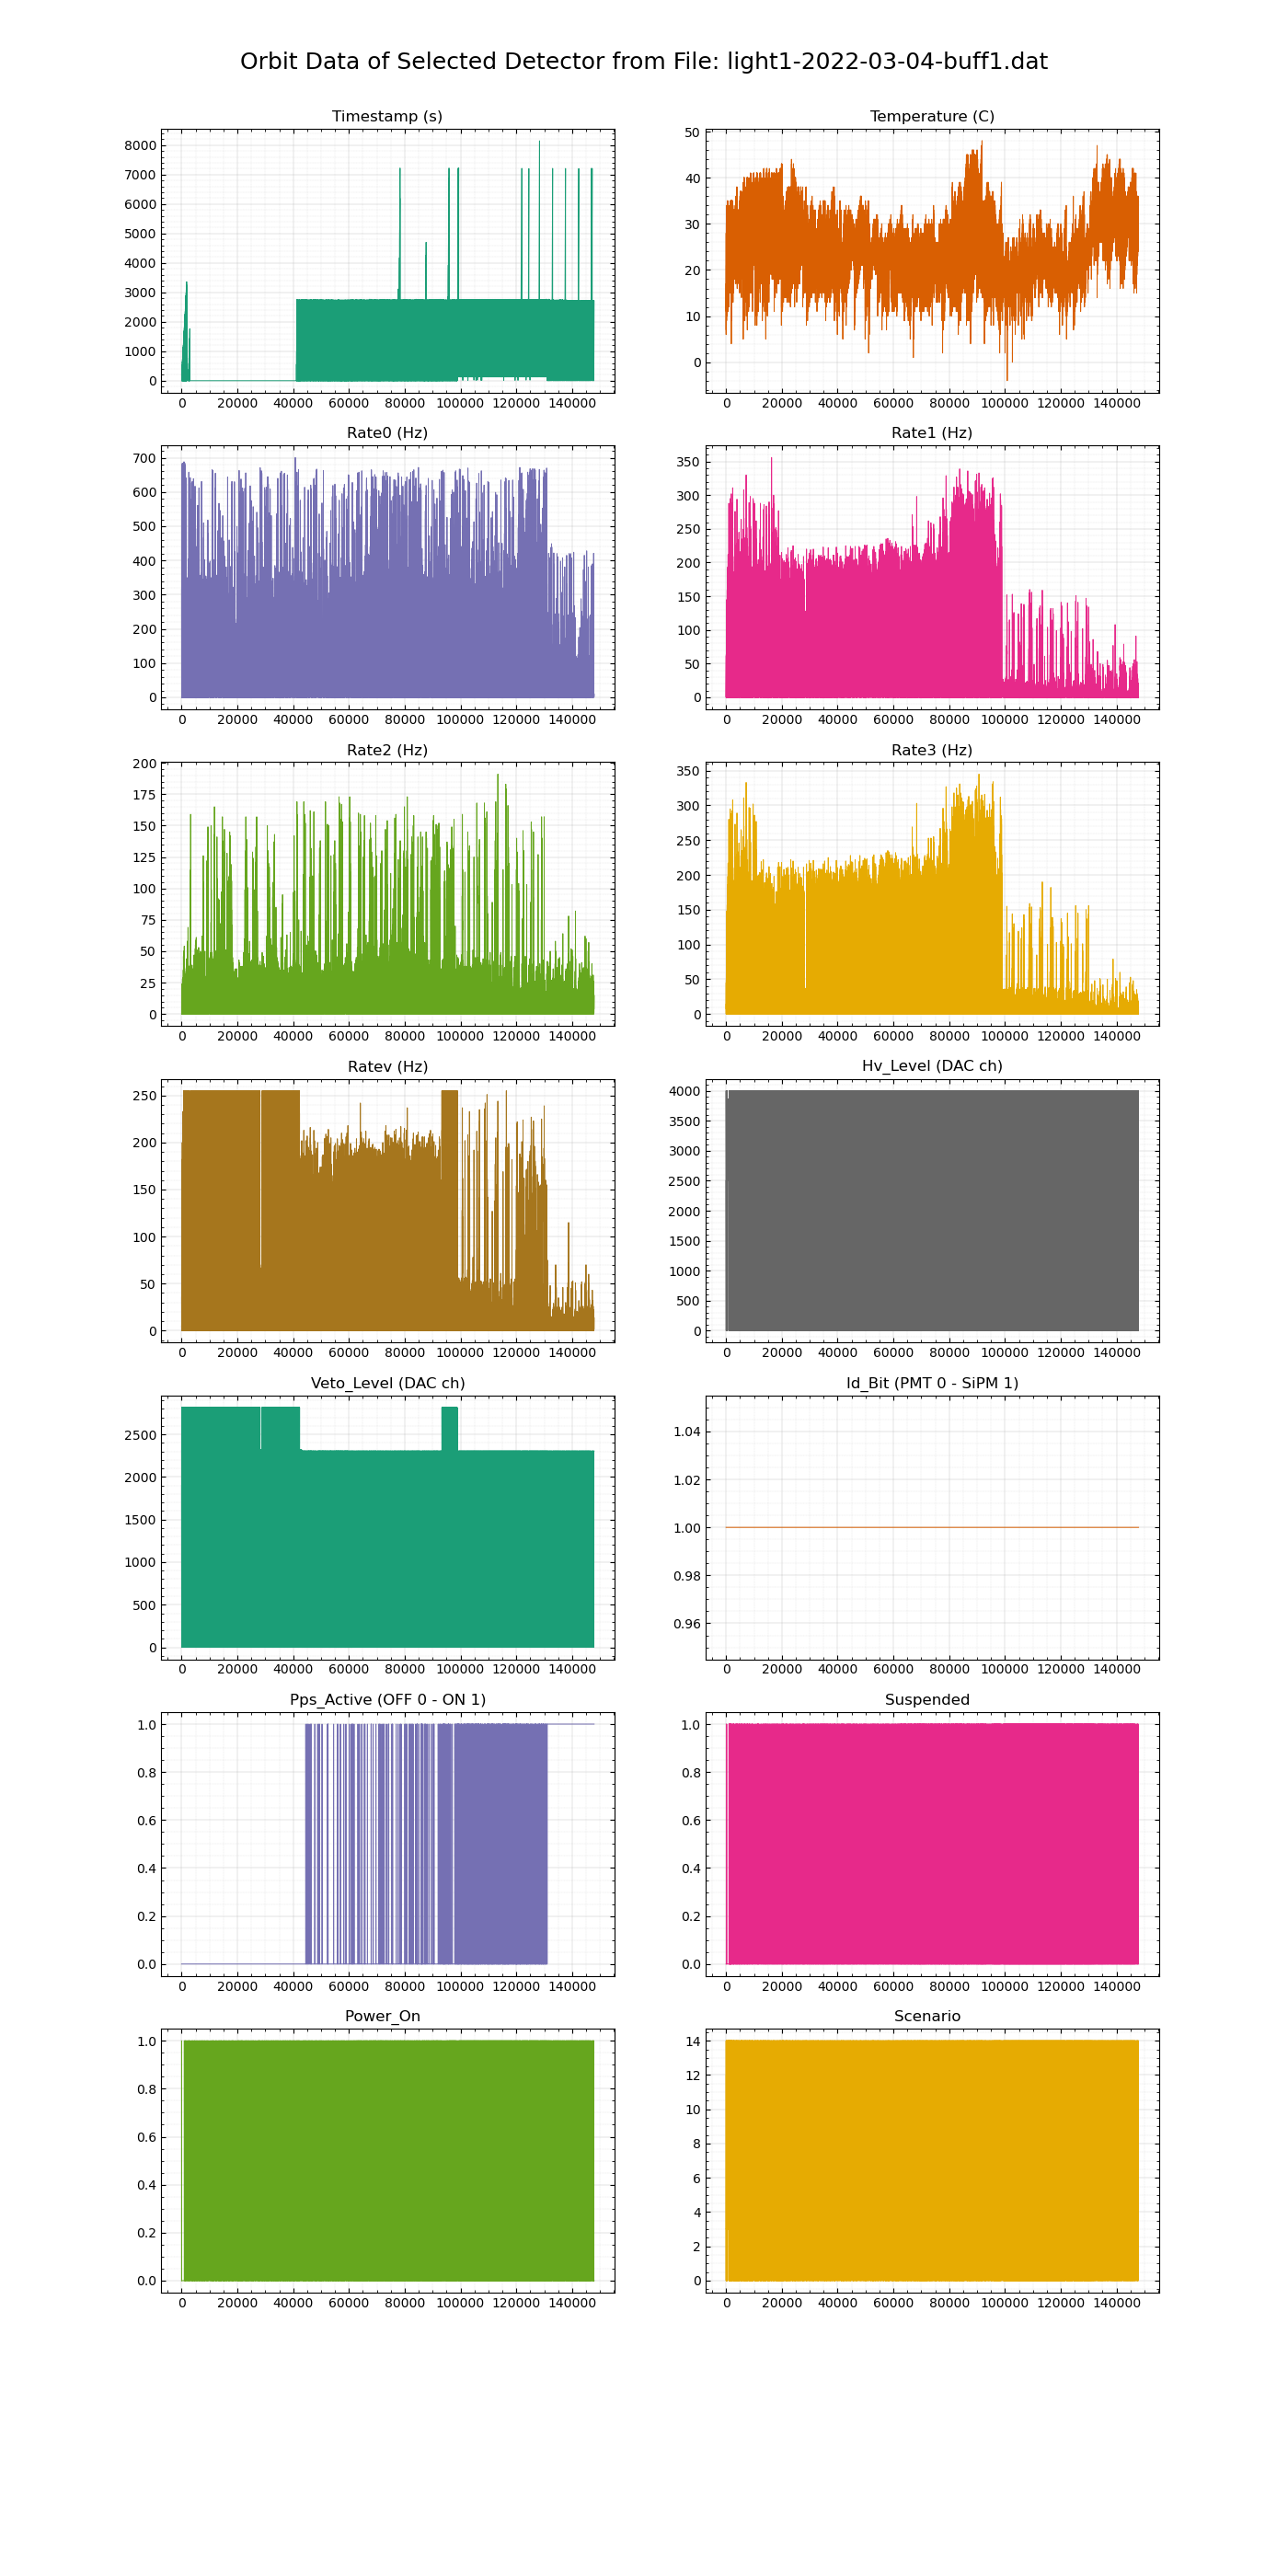

In [3]:
# Now print the Data
fig, axes  = rp.plot_buffer(full_data,title = 'Orbit Data of Selected Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

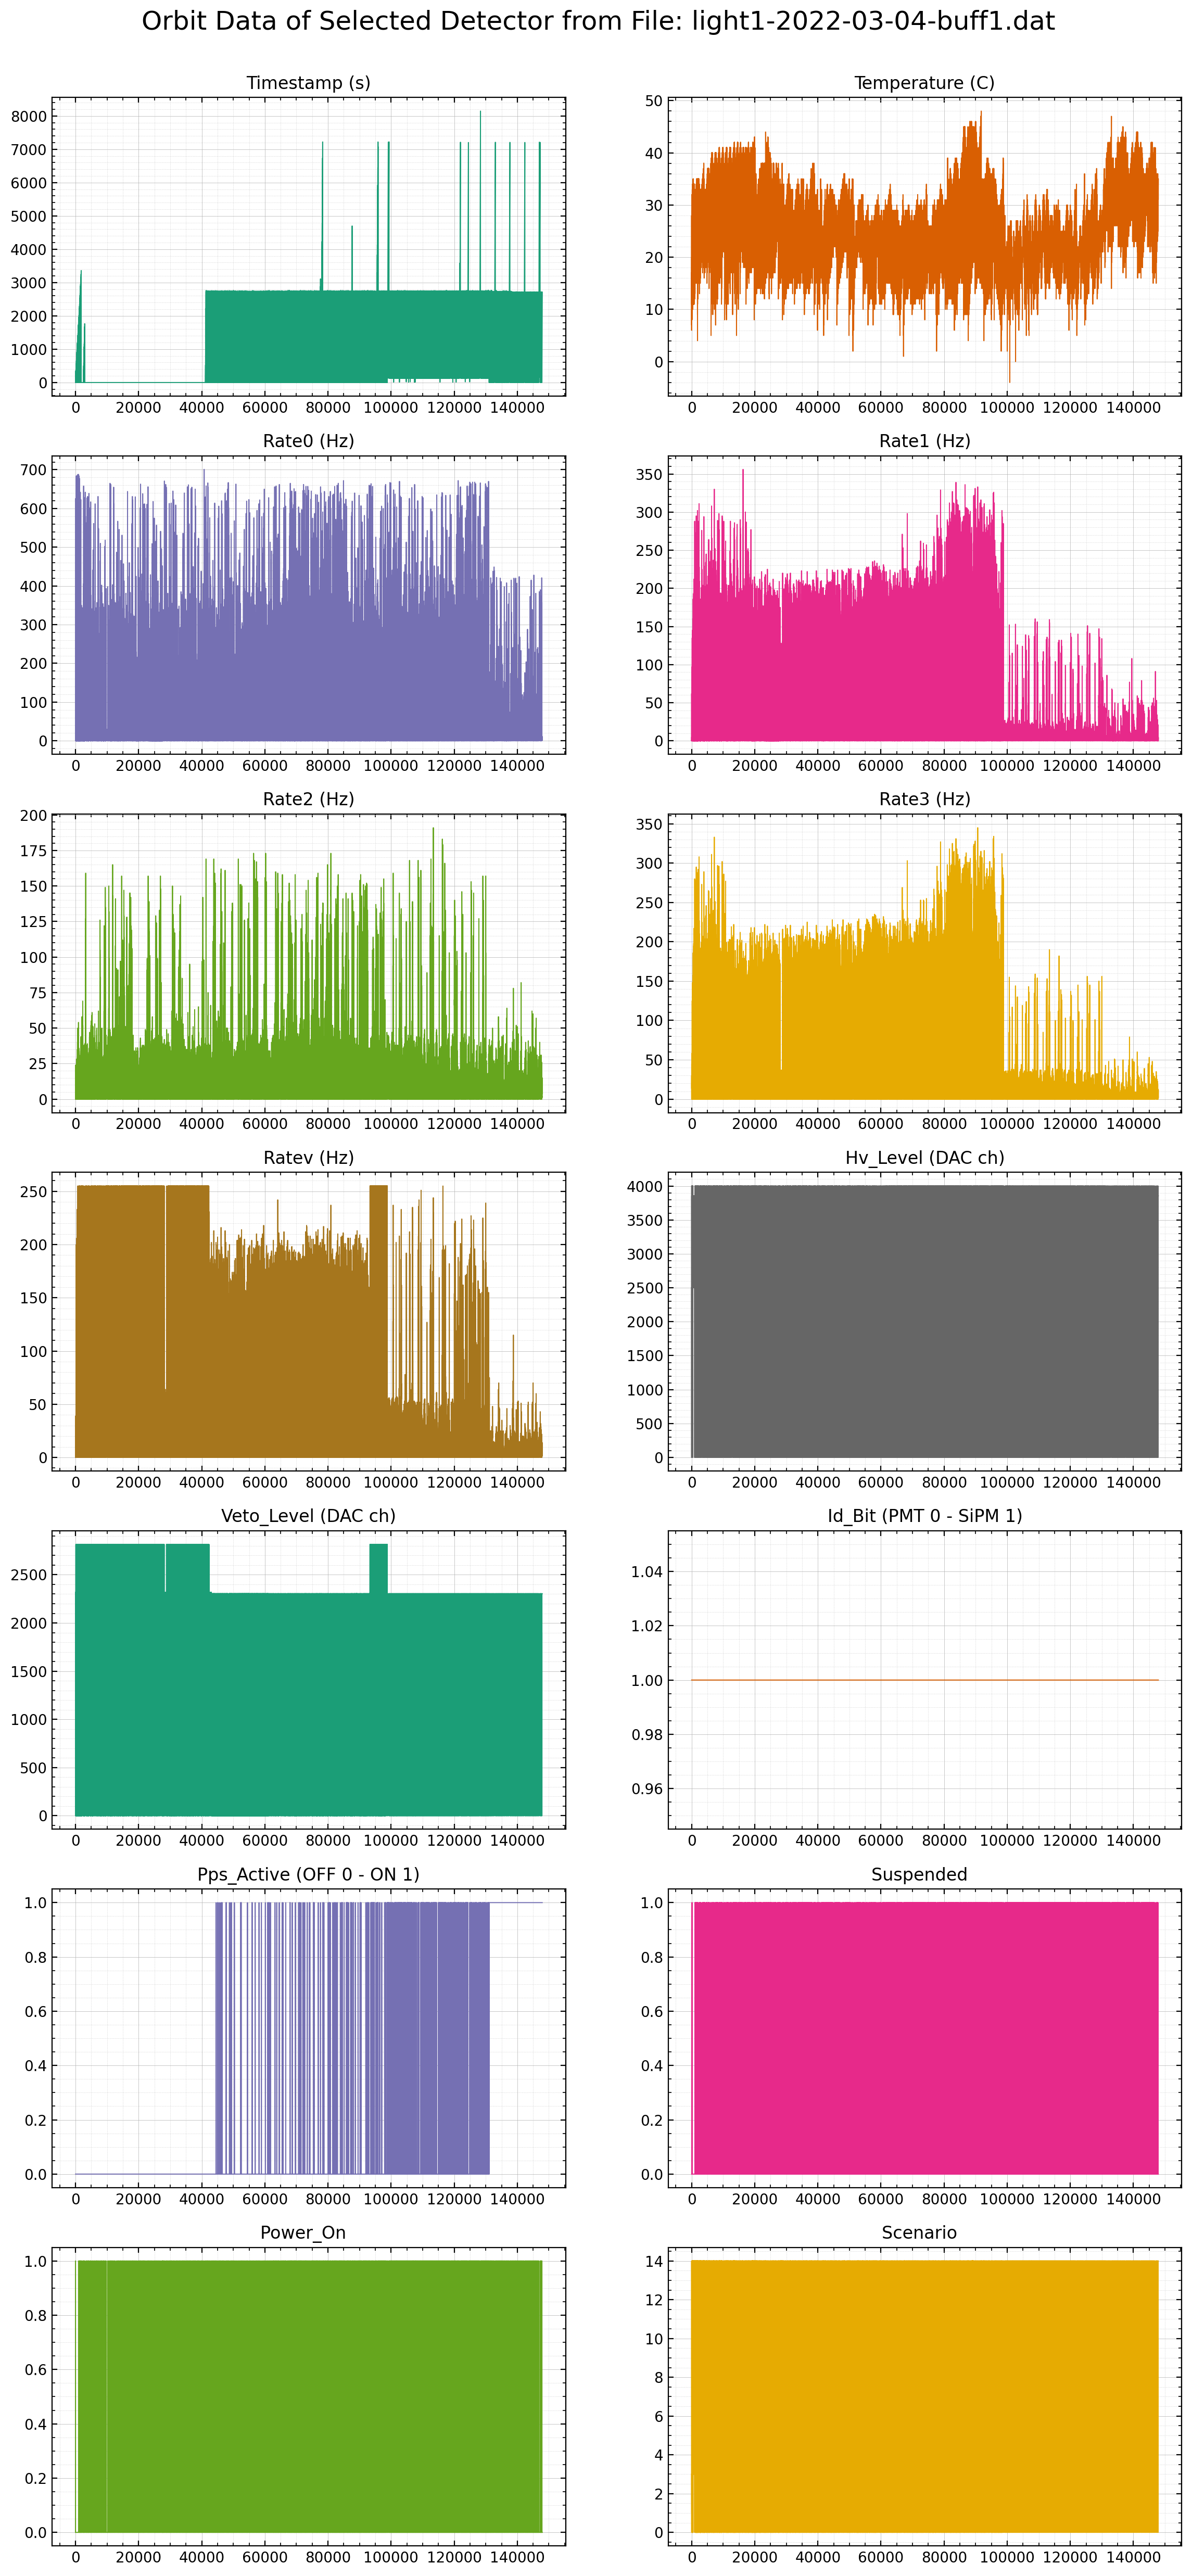

In [4]:
fig

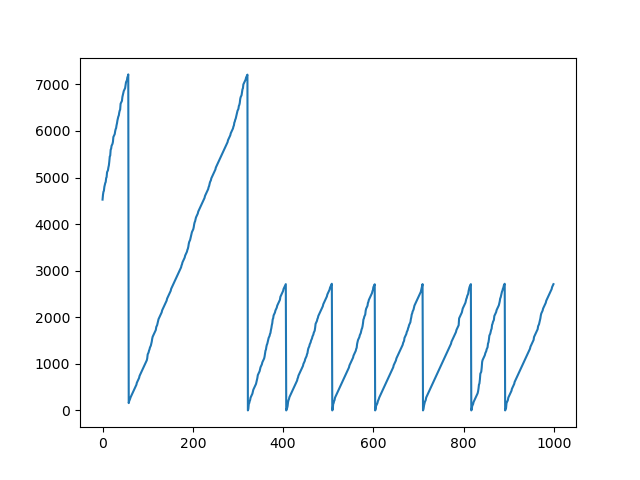

In [5]:
plt.figure()
plt.plot(full_data['timestamp'][-1000:])
plt.show()

In [6]:
# Clip the data to the regions of interest
TAIL    = 12000
data    = rp.subdict(full_data,-TAIL)

# Now we load the log file and find it's timestamps
log     = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log     = log[-int(TAIL/len(full_data['timestamp'])*3 * len(log)):]
log     = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing

Found weird command
 {'command': 'SE0>rtc read\n', 'output': ['curr rtc time 166247script delayuntil 1662516900\n', 'OK\n']}
Found weird command
 {'command': 'SE0>rtc read\n', 'output': ['curr rtc time 16657438script delayuntil 1665756900\n', 'OK\n']}
Found weird command
 {'command': 'SE0>script delay 18script delayuntil 1666075500\n', 'output': ['OK\n']}


In [7]:
# Helper functions #############################################

# Get the two arrays of different size and match their elements
def match(*arrays,from_end=True):
    # Length of the final arrays
    length = min([len(array) for array in arrays])

    # Concatenate the arrays
    if from_end:
        return [array[-length:] for array in arrays]
    else: 
        return [array[:length] for array in arrays]

# Collect timestamps of command execution
def collect_time_cmd(log:dict,cmd,include_end:bool=True):
    return np.array([line['timestamp'] for line in log if cmd in line['command']])

# Remove the dublicates
def remove_duplicates(array,mean:float=1,std:float=1,return_idx:bool=False,only_zeros:float=float('inf')):
    diff    = array[1:] - array[:-1]
    idx     = np.where(diff > mean*np.mean(diff) + std*np.std(diff))[0]
    idx     = np.array([i for i in idx if abs(array[i+1]) <= only_zeros])

    if return_idx: return idx
    return array[idx]

# Take an array and return an increasing version of it
def force_increasing(array):
    add     = 0
    output  = array.copy()
    for i in range(1,len(array)):
        if array[i] - array[i-1] < 0: add += array[i-1]
        output[i] += add

    return output

In [8]:
# Find the peaks in the timestamp
end_timestamps_idx      = remove_duplicates(-data['timestamp'],return_idx=True)           # Array of indices of the peaks
end_timestamps_idx      = np.append(end_timestamps_idx,[len(data['timestamp']) - 1])                    # Append the last index because it is a peak
start_timestamps_idx    = end_timestamps_idx[:-1] + 1

# Find the peaks in the logfile
PWR_ON_CMD              = 'txrx 4 14 600 0007010100'
PWR_OFF_CMD             = 'txrx 4 14 600 0007000000'
end_timestamps_log      = collect_time_cmd(log,PWR_OFF_CMD)
start_timestamps_log    = collect_time_cmd(log,PWR_ON_CMD)

In [9]:
# Match the two arrays from the back
end_timestamps_idx, end_timestamps_log, start_timestamps_idx, start_timestamps_log = match(end_timestamps_idx,end_timestamps_log,start_timestamps_idx,start_timestamps_log)

In [10]:
# Fill in the gaps in the logfile

# Nomralize the logfile
normed_timestamps = data['timestamp'].copy().astype('float')

# Normalize by tooth
for s,e in zip(start_timestamps_idx,end_timestamps_idx):
    normed_timestamps[s:e+1]    = force_increasing(normed_timestamps[s:e+1])
    temp_timestamp              = force_increasing(data['timestamp'][s:e+1])
    normed_timestamps[s:e+1]    = (normed_timestamps[s:e+1]- min(normed_timestamps[s:e+1]))/float(temp_timestamp[-1]-temp_timestamp[0])

# Finaly get the stupid timestamp
timestamp = []

# For each tooth
for i,(s,e) in enumerate(zip(start_timestamps_idx,end_timestamps_idx)):
    # For each element within the tooth
    min_time = start_timestamps_log[i]
    max_time = end_timestamps_log[i]
    for j in range(s,e+1):
        timestamp.append(normed_timestamps[j]*(max_time-min_time) + min_time)

timestamp = np.array(timestamp)

Text(0.5, 0.98, 'Reconstructed Time vs event number')

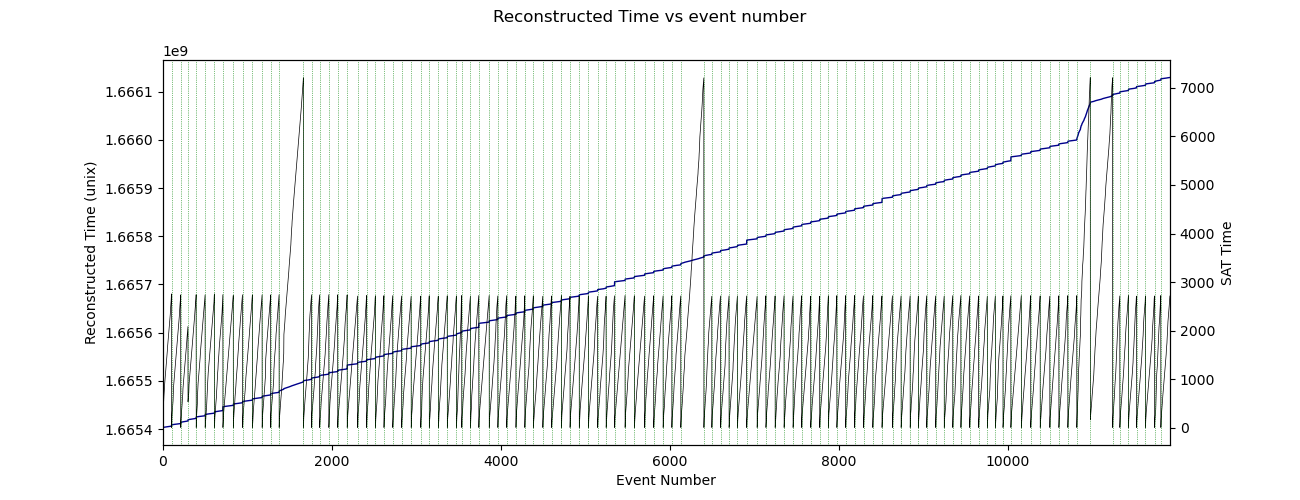

In [11]:
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

MIN = start_timestamps_idx[0]

ax1.plot(timestamp,c='darkblue',lw=1)
ax2.plot(data['timestamp'][MIN:],lw=0.5,c='k')
for i in start_timestamps_idx:
    ax2.axvline(i - MIN,c='g',lw=0.5,ls=':')

ax1.set_ylabel('Reconstructed Time (unix)')
ax2.set_ylabel('SAT Time')
ax1.set_xlabel('Event Number')
ax2.set_xlim(0,TAIL - MIN)
fig.suptitle('Reconstructed Time vs event number')


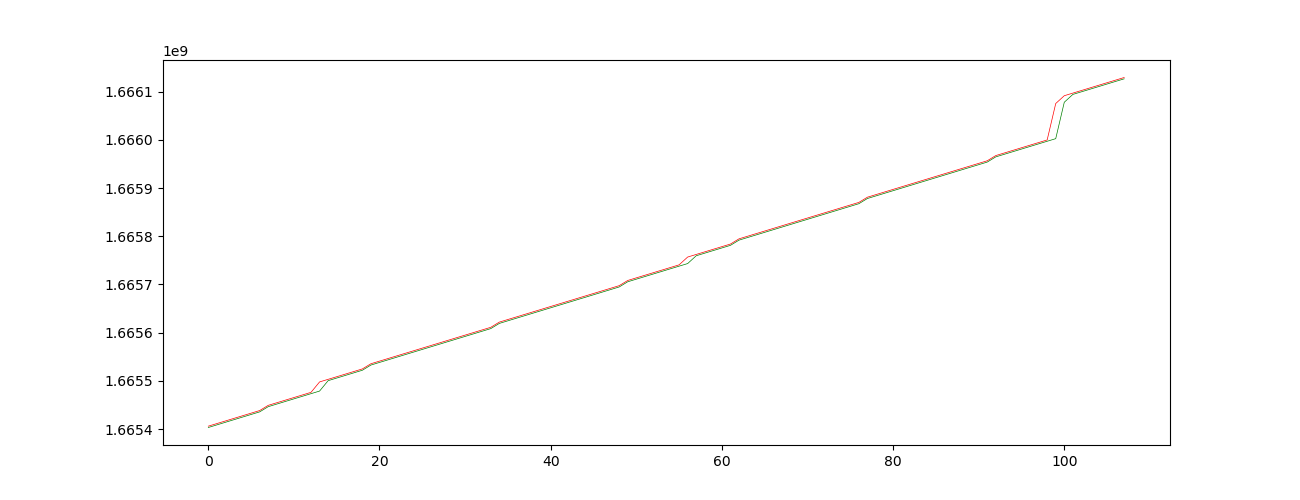

In [12]:
fig = plt.figure(figsize=(13,5))
plt.plot(start_timestamps_log,c='g',lw=0.5)
plt.plot(end_timestamps_log,  c='r',lw=0.5)


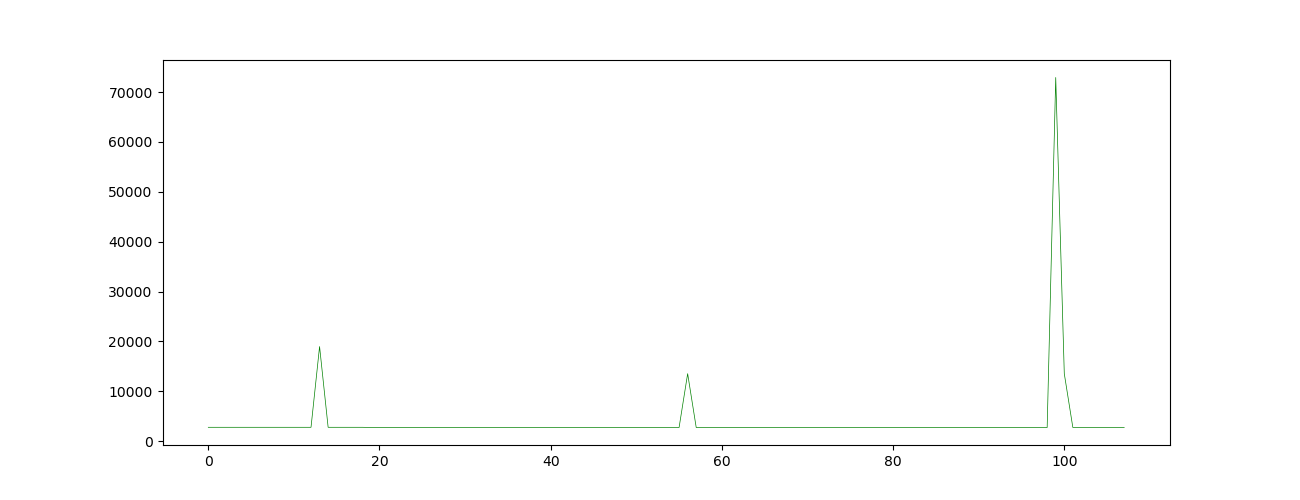

In [13]:
fig = plt.figure(figsize=(13,5))
plt.plot(end_timestamps_log-start_timestamps_log,c='g',lw=0.5)


# Plotting Maps and Histograms

In [15]:
# Convert to astropy object time
time_astro = [rp.Time(t,format='unix') for t in timestamp]# if  MIN <= t <= MAX]
print(len(time_astro))

# Get the location of the cubesat in this time
positions = rp.get_light1_position(min(time_astro),max(time_astro),n_events=10*len(time_astro))

11917
SELECT * FROM `LIGHT-1_Position_Data`.PositionData WHERE `Time (ModJDate)` BETWEEN 59862.500000177315 AND 59870.90653941896;


In [16]:
# Interpolate positions
def interpolate(array,timestamps):
    new_array   = rp.array([])
    old_time    = array.get_timestamps(format='unix').astype('float64')
    longs,lats  = array.get_coords().T
    for t in timestamps:
        new_array.append(rp.event(
            timestamp = rp.Time(t,format='unix'),
            latitude  = np.interp(t,old_time,lats),
            longitude = np.interp(t,old_time,longs),
            detector_id=0,
        ))

    return new_array

positions = interpolate(positions,timestamp)

In [17]:
rates = 0
for i in range(4): rates += data[f'rate{i}'][range(min(start_timestamps_idx),max(end_timestamps_idx)+1)]

rates = data['ratev'][range(min(start_timestamps_idx),max(end_timestamps_idx)+1)]

log_rates = np.array([2*max(0,np.log(r)) for r in rates])

temperatures = np.array(data['temperature'][min(start_timestamps_idx):max(end_timestamps_idx)+1])

map = rp.map(positions,color=rates,marker_size=log_rates,size=800);
map

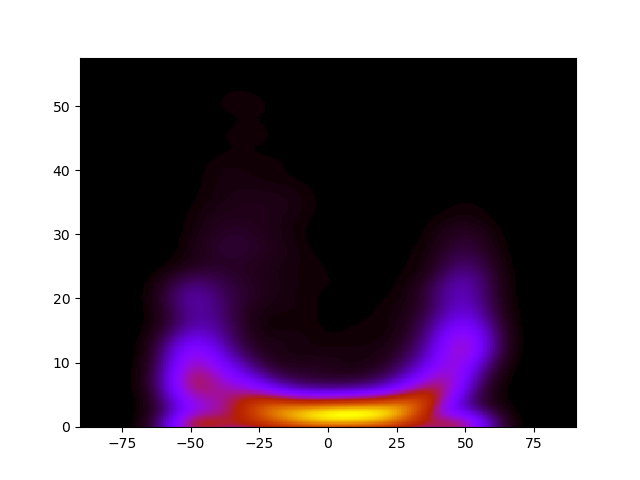

In [18]:
from scipy.stats import kde

longitudes, latitudes = positions.get_coords().T
longitudes_rep        = np.vstack([longitudes-(max(longitudes)-min(longitudes)),longitudes,longitudes+(max(longitudes)-min(longitudes))]).flatten()
latitudes_rep         = np.tile(latitudes,3)
nbins=300

k = kde.gaussian_kde([latitudes,rates])
xi, yi = np.mgrid[-90:90:nbins*1j, 0:max(rates)*0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),  shading='auto', cmap=plt.cm.gnuplot)
plt.show()

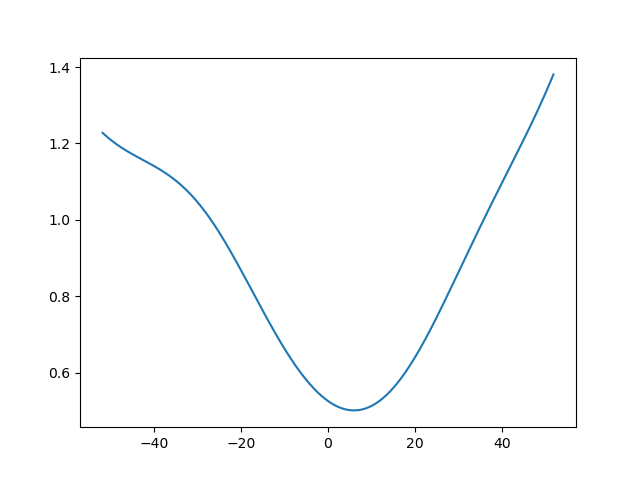

In [19]:
d = 0.4
k = kde.gaussian_kde(latitudes,d,weights=rates)
bg = kde.gaussian_kde(latitudes,d)

x = np.linspace(min(latitudes),max(latitudes),nbins)

plt.figure()
plt.plot(x,k(x)/bg(x))

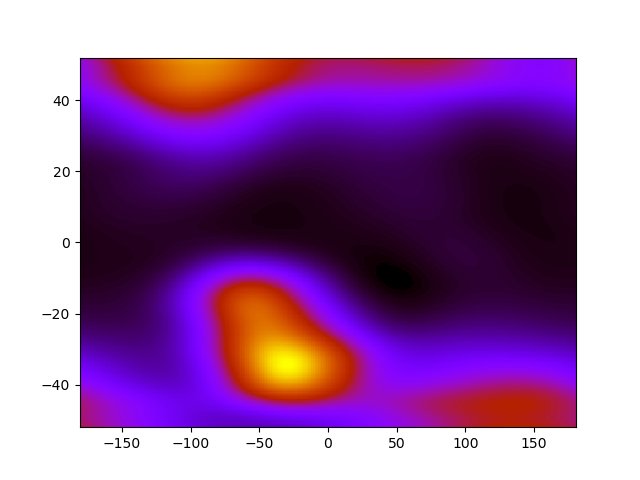

In [20]:
d = 0.1
k = kde.gaussian_kde([longitudes_rep,latitudes_rep],d,weights=np.tile(rates,3))
b = kde.gaussian_kde([longitudes_rep,latitudes_rep],d)

xi, yi = np.mgrid[-180:180:nbins*1j, min(latitudes):max(latitudes):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()])) /b(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),  shading='auto', cmap=plt.cm.gnuplot)
plt.show()

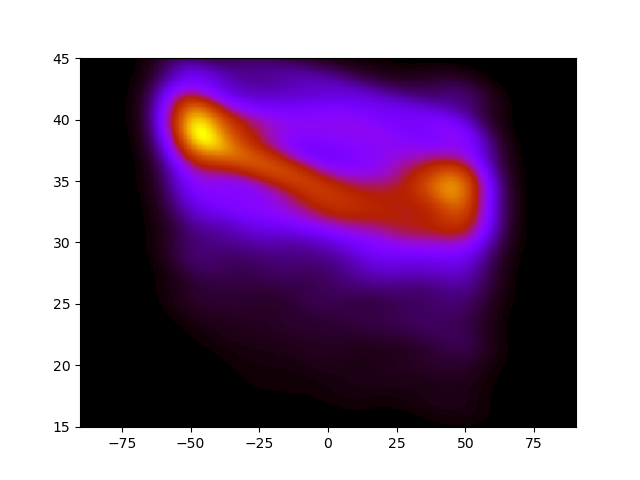

In [21]:
nbins=300

k = kde.gaussian_kde([latitudes,temperatures])
xi, yi = np.mgrid[-90:90:nbins*1j, min(temperatures):max(temperatures):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),  shading='auto', cmap=plt.cm.gnuplot)
plt.show()

# Create a stupid 3D plot with all this crap

In [22]:
# Get 3D Coordinates from latitude and longitude
def global_to_cartesian(lon, lat, radius=1):
    xs=radius*np.cos(lon*np.pi/180.)*np.cos(lat*np.pi/180.)
    ys=radius*np.sin(lon*np.pi/180.)*np.cos(lat*np.pi/180.)
    zs=radius*np.sin(lat*np.pi/180.)
    return xs, ys, zs

# An ugly colorscale
colorscale=[
    [0.0, '#313695'],
    [0.07692307692307693, '#3a67af'],
    [0.15384615384615385, '#5994c5'],
    [0.23076923076923078, '#84bbd8'],
    [0.3076923076923077, '#afdbea'],
    [0.38461538461538464, '#d8eff5'],
    [0.46153846153846156, '#d6ffe1'],
    [0.5384615384615384, '#fef4ac'],
    [0.6153846153846154, '#fed987'],
    [0.6923076923076923, '#fdb264'],
    [0.7692307692307693, '#f78249'],
    [0.8461538461538461, '#e75435'],
    [0.9230769230769231, '#cc2727'],
    [1.0, '#a50026']]

In [23]:
# Parameters of the sphere
NPTS    = 200
lon     = np.linspace(-180,180,NPTS)
lat     = np.linspace(min(latitudes),max(latitudes),NPTS)
lon,lat = np.meshgrid(lon,lat)
x,y,z   = global_to_cartesian(lon,lat,radius=1)

# Estimate the rate function
d       = 0.1
k       = kde.gaussian_kde([longitudes_rep,latitudes_rep],d,weights=np.tile(rates,3))
b       = kde.gaussian_kde([longitudes_rep,latitudes_rep],d)
RATE    = k(np.vstack([lon.flatten(), lat.flatten()]))/b(np.vstack([lon.flatten(), lat.flatten()]))
RATE    = RATE.reshape(lon.shape)/np.max(RATE)
RATE[:, lon.shape[1]-1]=np.copy(RATE[:, 0])

In [24]:
# Data
e = 1e-1
sphere = dict(type='surface',
            x=x*(1+e*RATE), 
            y=y*(1+e*RATE), 
            z=z,#*(1+e*RATE),
            colorscale=colorscale,
            surfacecolor=RATE,
            cmin=0,
            cmax=1,
            opacity=0.99,
            colorbar=dict(thickness=20, len=0.75, ticklen=4, title= 'Rate'),
            # text=text,
            hoverinfo='none')

In [25]:
# Parameters of the sphere
NPTS    = 200
lon     = np.linspace(-180,180,NPTS)
lat     = np.linspace(-90,90,NPTS)
lon,lat = np.meshgrid(lon,lat)
xi,yi,zi= global_to_cartesian(lon,lat,radius=0.99)

bg_sphere = dict(type='surface',
            x=xi, 
            y=yi, 
            z=zi,
            surfacecolor=np.zeros(z.shape),
            colorscale=[[0.0,'#ffffff'],[1.0,'#ffffff']],
            opacity=1,
            showscale=False,
            # text=text,
            hoverinfo='none')

In [26]:
noaxis=dict(showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks='',
            title='',
            zeroline=False)

layout3d=dict(title='Rates of cubesat data over some time in october',
              font=dict(family='Balto', size=14),
              width=800, 
              height=800,
              scene=dict(xaxis=noaxis, 
                         yaxis=noaxis, 
                         zaxis=noaxis,
                         aspectratio=dict(x=1,
                                          y=1,
                                          z=1),
                         camera=dict(eye=dict(x=1.15, 
                                     y=1.15, 
                                     z=1.15)
                                    )
            ),
            paper_bgcolor='rgba(255,255,255, 0.9)'  
           )

In [28]:
fig = rp.go.Figure(data=[sphere,bg_sphere], layout=layout3d)
fig

ValueError: 
    Invalid value of type 'builtins.int' received for the 'z' property of surface
        Received value: 1

    The 'z' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series